In [4]:
import torch
import torchvision
import shutil 

batch_size= 32

mean = -1
std=1
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../datasets/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize([32, 32]),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (mean,), (std,))
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../datasets/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize([32, 32]),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (mean,), (std,))
                             ])),
  batch_size=16, shuffle=False, drop_last= True)

for x,y in train_loader:
    break
    
vmin= x.min().item()
vmax= x.max().item()
print('range : ',vmin, vmax)

range :  1.0 2.0


In [6]:
%load_ext autoreload
%autoreload 2

import torch
import shutil 
import numpy as np
from torch import nn
from modules.kernels import get_gaussian
from modules.models.decoder import simple_generator
from modules.models.forward_model import forward_modelA
from modules.models.forward_H import modelH
from modules.train_utils_v2 import train
from modules.custom_activations import inc_m
import matplotlib.pyplot as plt
from modules.models.preprocess_H_weights import ifft, fft
from modules.noise import poisson_noise
from modules.models.classifiers import simple_mnist_classifier

device='cuda:0' if torch.cuda.is_available() else 'cpu'

classifier = simple_mnist_classifier(32).to(device)
classifier.load_state_dict(torch.load('saved_models/mnist_classifier.pth', map_location=device)['model_state_dict'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<All keys matched successfully>

In [7]:
img_size= 32
m_inc_epoc= 1

def inc_1_after_100_interval_10(m, epoch):
    if epoch>150 and epoch%10==0:
        m=inc_m(m, epoch, 1)
    return m

sPSF= torch.tensor(get_gaussian(side_len=5, s=1)).float().to(device)
exPSF= torch.tensor(get_gaussian(side_len=5, s=1)).float().to(device)

criterion= nn.L1Loss().to(device)
train_model_iter, train_H_iter= 1, 1
epochs=200
show_results_epoch=10
initialization_bias= 10

Let's use 2 GPUs!
device : cuda:0
m : 1
yt range : [-1.3264153003692627 1.523333191871643]
yt range : [-1.1530492305755615 1.3894290924072266]
show images : X range : [1.0, 2.0]
show images : X_hat range : [0.6679180264472961, 1.0229568481445312]
tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')


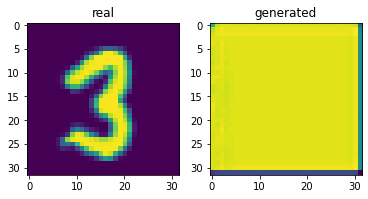

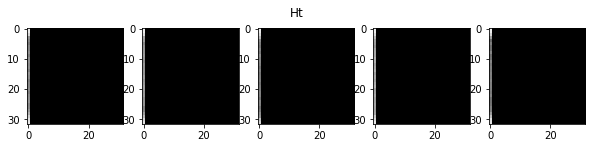

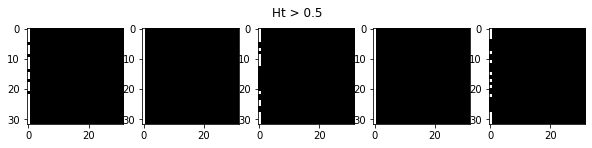

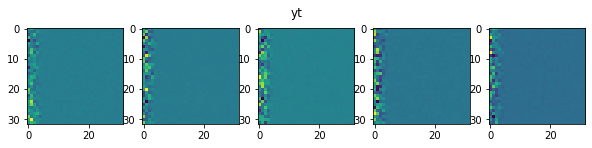

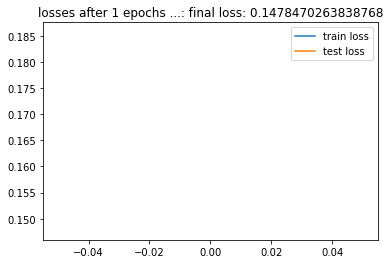

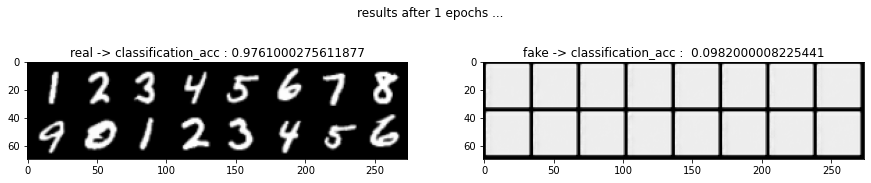

m : 1



KeyboardInterrupt



In [14]:
from modules.models.forward_H import modelH
from modules.train_utils_v2 import train
from modules.custom_activations import sigmoid_custom2 as H_activation

T=5
H_complex_init =True
H_weight_preprocess= ifft #torch.abs #torch.abs #None
m_inc_proc =None #inc_m

decoder= simple_generator(T, img_size)
H_generator = modelH(T, 32, H_weight_preprocess, H_complex_init, device, initialization_bias=10, activation = H_activation)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    decoder = nn.DataParallel(decoder)
    #H_generator= nn.DataParallel(H_generator)

decoder.to(device)
H_generator.to(device)

opt_model= torch.optim.Adam(decoder.parameters(), lr= 0.001)
opt_H= torch.optim.Adam(H_generator.parameters(), lr= 0.01)

noise=True # gradient exploding is not there (because I have added change the image range [1,2] -> which not contains 0s in it: forward_model.py)
train_model_iter, train_H_iter= 1, 1

train(decoder, forward_modelA, H_generator, sPSF, exPSF, criterion, [opt_model, opt_H], train_loader, test_loader, device, T, 10, 1, train_model_iter, train_H_iter, m_inc_epoc, m_inc_proc, './1', noise, classifier, [mean, std])
